# Case Study

# Objective

Train a simple deep nerual netowrk (DNN) to classify between groups of subjects


# Background

Heart disease is the leading cause of death globally. __Heart failure__ and __Hypertrophic cardiomyopathy__  are the primary cause of heart diseases, and that refers to a physiological state in which the heart is unable to pump sufficiently to maintain blood flow to meet the body's need. It usually occurs because the heart has become too weak or stiff. 

HF is routinely diagnosed by:
* __Electrocardiogram (ECG)__, which measure heart's rhythm and electrical activity. From the ECG the QRS duration can be computed. An increased QRS duration, indicate dyssynchronous contraction and relaxation of the left and right ventricles and it is a marker of detection of HF subjects.
* __MRI__ or __US imaging__ which provides structural and functional information of the heart. Evaluation of the structure and the function of the ventricles can provide useful information for diagnosis and characterization of disease. 
 	 	
Based on the result of these tests, doctors use NYHA class to classify patients' heart failure according to the severity of their symptoms:

__Class I__: no limitation is experienced in any activities; there are no symptoms from ordinary activities.

__Class II__: slight, mild limitation of activity; the patient is comfortable at rest or with mild exertion.

__Class III__: marked limitation of any activity; the patient is comfortable only at rest.

__Class IV__: any physical activity brings on discomfort and symptoms occur at rest.

### Current diagnostic technique

Currently, the parameters used in clinics to identify cardiac patients are:
* __LVEDV__ which is the maximum amount of blood that heart can pump
* __LVESV__ which is the minium amount of blood that heart can pump
* __LVSV__ which is the amount of blood pumped by the left ventricle of the heart in one contraction. 
* __Ejection fraction (EF)__, which computes the amount of blood of the left ventricle (LV) pumps out with each contraction. A normal heart’s ejection fraction may be between 50 and 70 percent.


### Analsysis

In this case study we aim develop a DNN network to classify between the healthy, heart failure and hypertrophic cardiomyopathy subjects.

# Imports

In [1]:
from __future__ import print_function, division

import os

import numpy as np
import pylab as plt
import torch
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch.nn import functional as F



# Functions

In [2]:
def compute_metrics(y_true, yPred, target_names):
    """ Compute metrics
    Parameters
    ----------
    yPred: labels predicted using DNN
    y_true: ground truth labels
    target_names:  names matching the labels
    """

    BACC = balanced_accuracy_score(y_true, yPred)
    PRE = precision_score(y_true, yPred, average=None)
    REC = recall_score(y_true, yPred, average=None)
    print('Balanced accuracy  {0:.2f}'.format(BACC))

    headers = ["precision", "recall"]

    rows = zip(target_names, PRE, REC)

    digits = 2
    longest_last_line_heading = 'weighted avg'
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = u'{:>{width}s} ' + u' {:>9}' * len(headers)
    report = head_fmt.format(u'', *headers, width=width)
    report += u'\n\n'
    row_fmt = u'{:>{width}s} ' + u' {:>9.{digits}f}' + u' {:>9}\n'
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    report += u'\n'

    print(report)

    return BACC * 100, PRE * 100, REC * 100

class DNN_generic(torch.nn.Module):
    '''Plain dense neural network of linear layers using dropout and ReLU activation.'''

    def __init__(self, inChannels, outChannels, hiddenChannels, dropout=0, bias=True):
        '''
        Defines a network accept input with `inChannels' channels, output of `outChannels' channels, and hidden layers
        with channels given in `hiddenChannels'. If `bias' is True then linear units have a bias term.
        '''
        super().__init__()
        self.inChannels = inChannels
        self.outChannels = outChannels
        self.dropout = dropout
        self.hiddenChannels = list(hiddenChannels)
        self.hiddens = torch.nn.Sequential()

        prevChannels = self.inChannels
        for i, c in enumerate(hiddenChannels):
            self.hiddens.add_module('hidden_%i' % i, self._getLayer(prevChannels, c, bias))
            prevChannels = c

        self.output = torch.nn.Linear(prevChannels, outChannels, bias)

    def _getLayer(self, inChannels, outChannels, bias):
        return torch.nn.Sequential(
            torch.nn.Linear(inChannels, outChannels, bias),
            torch.nn.Dropout(self.dropout),
            torch.nn.ReLU()
        )

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        x = self.hiddens(x)
        x = self.output(x)
        return F.softmax(x, 1)


class DNN(torch.nn.Module):
    '''Plain dense neural network of linear layers using dropout and ReLU activation.'''

    def __init__(self, numClasses):
        super().__init__()
        self.hiddens = torch.nn.Sequential(
            torch.nn.Linear(4, 20),
            torch.nn.Dropout(0.05),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.Dropout(0.05),
            torch.nn.ReLU(),
            torch.nn.Linear(10, numClasses),
        )

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        x = self.hiddens(x)
        return F.softmax(x, 1)

# Set paths and hyperparameters

In [3]:
# If you use google cloab
![ -f data.npz ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/data.npz
data_file_name = 'data.npz'
nb_iters = 100000

# If you use local Anaconda
# data_dir = '/home/epu14/SummerSchool' # Modify this path to your own directory!!
# data_file_name = 'data.npz'
# data_file_name = os.path.join(data_dir, data_file_name)
#  nb_iters = 100000

# Compute cardiac metrics

First load the data and based on the segmentations compute:

- LVEDV (maximum volume of the cardiac cycle)
- LVESV (minimum volume of the cardiac cycle)
- LVSV = LVEDV - LVESV 
- LVEF = LVSV/LVEDV*100 

Then:
- Generate a matrix ```metrics``` that concatenate LVEDV, LVESV, LVSV and LVEF

In [5]:
# 1. Load the data
data = np.load(data_file_name)

# 2. Save fields inside data
images = data['images']  # (805, 128, 128)
segs = data['segs']  # (805, 128, 128)
caseNames = data['caseNames']  # 45
caseIndices = data['caseIndices']  # 45
caseTypeNames = data[
    'caseTypeNames']  # ['Normal', 'Heart Failure With Infarct', 'Heart Failure Without Infarct', 'Hypertrophy']
caseVoxelSize = data['caseVoxelSize']
caseTypes = data['caseTypes']  # 45
isEDImg = data['isEDImg']  # 805
segTypes = data['segTypes']  # ['Background', 'LV Pool', 'Myocardium']

# 3. Compute LVEDV, LVESV, LVSV and LVEF
metrics = np.zeros((len(caseNames), 4))
for ii, ind in enumerate(caseIndices):
    indED_pat = isEDImg[ind[0]:ind[1]]
    img_pat = images[ind[0]:ind[1], :, :]
    seg_pat = segs[ind[0]:ind[1], :, :]
    img_ED = img_pat[indED_pat, :, :]
    img_ES = img_pat[~indED_pat, :, :]
    seg_ED = seg_pat[indED_pat, :, :]
    seg_ES = seg_pat[~indED_pat, :, :]
    dx, dy, dz = caseVoxelSize[ii]
    volume_per_voxel = dx * dy * dz * 1e-3
    density = 1.05

    metrics[ii, 0] = np.sum(np.sum(seg_ED == 1, axis=1)) * volume_per_voxel
    metrics[ii, 1] = np.sum(np.sum(seg_ES == 1, axis=1)) * volume_per_voxel
    metrics[ii, 2] = metrics[ii, 0] - metrics[ii, 1]
    metrics[ii, 3] = metrics[ii, 2] / metrics[ii, 0] * 100


# Visualize the data

Plot LVEDV, LVESV, LVSV and LVEF per groups, i.e. LVEDV and LVESV, LVSV and LVEF

Text(0, 0.5, 'LVEF')

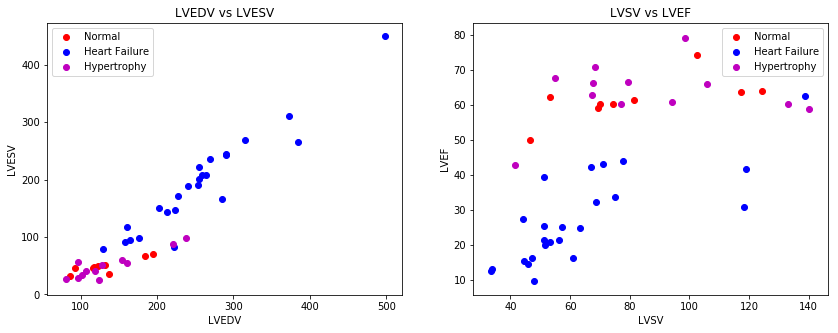

In [6]:
def PlotThreeClassData(X,y, title, caseTypeNames):
    plt.scatter(X[y==0,0],X[y==0,1],c='r', label = caseTypeNames[0])
    plt.scatter(X[y==1,0],X[y==1,1],c='b', label = caseTypeNames[1])
    plt.scatter(X[y==2,0],X[y==2,1],c='m', label = caseTypeNames[2])
    plt.legend()
    plt.title(title)

plt.figure(figsize = [14,5])
plt.subplot(121)
PlotThreeClassData(metrics[:,0:2], caseTypes, 'LVEDV vs LVESV', caseTypeNames)
plt.xlabel('LVEDV')
plt.ylabel('LVESV')

plt.subplot(122)
PlotThreeClassData(metrics[:,2:], caseTypes, 'LVSV vs LVEF', caseTypeNames)
plt.xlabel('LVSV')
plt.ylabel('LVEF')


# Split data into training and test

Data is unbalanced (there is no the same number of patients per group). We need to ensure that in the split training/test there is balanced number of classed. To this end use StratifiedShuffleSplit from scikit-learn that will automatically ensure that.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes):
    X_train, X_test = metrics[train_index, :], metrics[test_index, :]
    y_train, y_test = caseTypes[train_index], caseTypes[test_index]

# Train a DNN network to perform classification


10000 0.7925359010696411
20000 0.7742582559585571
30000 0.7736721634864807
40000 0.7737149000167847
50000 0.7737371921539307
60000 0.7736679911613464
70000 0.7460464835166931
80000 0.7467410564422607
90000 0.7734676003456116
100000 0.7736671566963196


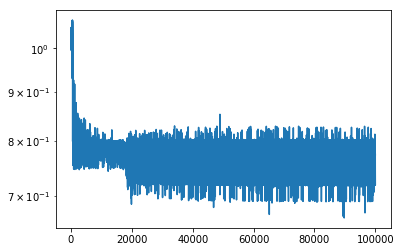

In [9]:
output_size = len(np.unique(caseTypes))
net = DNN(output_size)

xt = torch.from_numpy(X_train).type(torch.FloatTensor)
yt = torch.from_numpy(y_train).type(torch.LongTensor)

loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
opt = torch.optim.Adam(net.parameters(), lr=0.0001)

losses = []

for i in range(1, nb_iters + 1):
    out = net(xt)  # input x and predict based on x
    loss = loss_func(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    opt.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    opt.step()  # apply gradients

    losses.append(loss.item())

    if i % (nb_iters // 10) == 0:
        print(i, losses[-1])

plt.figure()
plt.semilogy(losses)
plt.show()


# Deploy network and compute metrics

First deploy the trained netowrk and then compute the following metrics: balanced accuracy, precision, recall


In [10]:
with torch.no_grad():
    net.eval()
    out = torch.from_numpy(X_test).float()
    out = net(out).data.numpy()
    y_pred = np.argmax(out, axis=1)

    # Compute metrics
    compute_metrics(y_test, y_pred, caseTypeNames)

Balanced accuracy  0.67
               precision    recall

       Normal       0.00       0.0
Heart Failure       1.00       1.0
  Hypertrophy       0.50       1.0




/home/epu14/code/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Case study 2

Redo the same experiment but comparing healthy vs hypertrophic patients and __Healthy__ vs __Hypertrophic cardiomyopathy__ patients 


10000 0.4884355366230011
20000 0.5071763396263123
30000 0.5351657867431641
40000 0.47998127341270447
50000 0.45882973074913025
60000 0.47994619607925415
70000 0.48011842370033264
80000 0.4799444377422333
90000 0.47994354367256165
100000 0.47996971011161804
Balanced accuracy  0.75
              precision    recall

      Normal       0.88       1.0
Hypertrophic       1.00       0.5




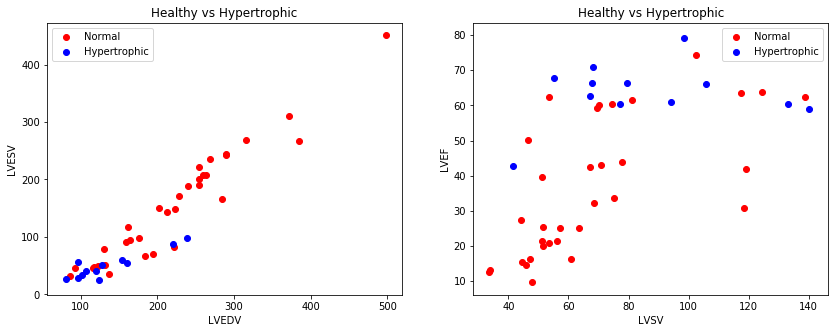

In [11]:
def PlotTwoClassData(X, y, title, _caseTypeNames):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', label=_caseTypeNames[0])
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', label=_caseTypeNames[1])
    plt.legend()
    plt.title(title)

################# Case 2: healthy vs Hypertrophy ################# 

# 1. Generate new labels
caseTypes2 = np.copy(caseTypes)
caseTypes2[caseTypes2 == 1] = 0
caseTypes2[caseTypes2 == 2] = 1
caseTypeNames2 = ['Non-Hypertrophic', 'Hypertrophic']

# 2. Plot data
plt.figure(figsize=[14, 5])
plt.subplot(121)
PlotTwoClassData(metrics[:, 0:2], caseTypes2, 'Non-Hypertrophic vs Hypertrophic', caseTypeNames2)
plt.xlabel('LVEDV')
plt.ylabel('LVESV')
plt.subplot(122)
PlotTwoClassData(metrics[:, 2:], caseTypes2, 'Non-Hypertrophic vs Hypertrophic', caseTypeNames2)
plt.xlabel('LVSV')
plt.ylabel('LVEF')

# 3. Split training/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes2):
    X2_train, X2_test = metrics[train_index, :], metrics[test_index, :]
    y2_train, y2_test = caseTypes2[train_index], caseTypes2[test_index]

# 4. Train DNN
output_size = len(np.unique(caseTypes2))
net2= DNN(output_size)

xt = torch.from_numpy(X2_train).type(torch.FloatTensor)
yt = torch.from_numpy(y2_train).type(torch.LongTensor)

loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
opt = torch.optim.Adam(net2.parameters(), lr=0.0001)

losses = []

for i in range(1, nb_iters + 1):
    out = net2(xt)  # input x and predict based on x
    loss = loss_func(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    opt.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    opt.step()  # apply gradients

    losses.append(loss.item())

    if i % (nb_iters // 10) == 0:
        print(i, losses[-1])

# 5. Deploy DNN
with torch.no_grad():
    net2.eval()
    out = torch.from_numpy(X2_test).float()
    out = net2(out).data.numpy()
    y2_pred = np.argmax(out, axis=1)

    # Compute metrics
    compute_metrics(y2_test, y2_pred, caseTypeNames2)

# Case study 3

Redo the same experiment but comparing healthy vs hypertrophic patients and __Healthy__ vs __Heart Failure__ patients 


10000 0.31328073143959045
20000 0.3132616877555847
30000 0.3132619261741638
40000 0.3132616877555847
50000 0.31326165795326233
60000 0.31326165795326233
70000 0.31326165795326233
80000 0.31326165795326233
90000 0.31326165795326233
100000 0.31326165795326233
Balanced accuracy  0.90
               precision    recall

       Normal       0.80       1.0
Heart Failure       1.00       0.8




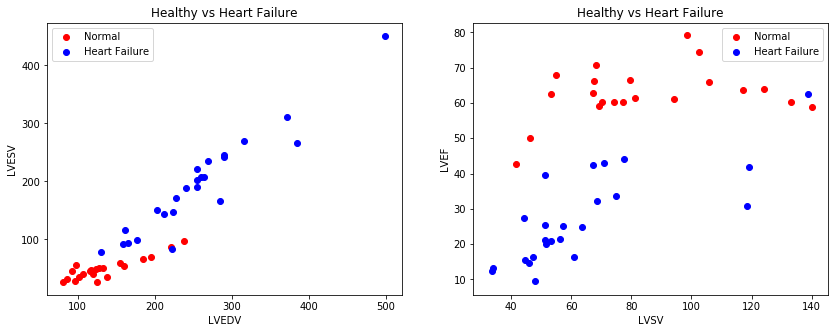

In [10]:
################# Case 3: healthy vs Heart Failure patients ################# 

# 1. Generate new labels
caseTypes3 = np.copy(caseTypes)
caseTypes3[caseTypes3 == 2] = 0
caseTypeNames3 = ['Normal', 'Heart Failure']

# 2. Plot data
plt.figure(figsize = [14,5])
plt.subplot(121)
PlotTwoClassData(metrics[:,0:2], caseTypes3, 'Healthy vs Heart Failure', caseTypeNames3)
plt.xlabel('LVEDV')
plt.ylabel('LVESV')
plt.subplot(122)
PlotTwoClassData(metrics[:,2:], caseTypes3, 'Healthy vs Heart Failure', caseTypeNames3)
plt.xlabel('LVSV')
plt.ylabel('LVEF')

# 3. Split training/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes3):
    X3_train, X3_test = metrics[train_index, :], metrics[test_index, :]
    y3_train, y3_test = caseTypes3[train_index], caseTypes3[test_index]

# 4. Train DNN
output_size = len(np.unique(caseTypes3))
net3= DNN(output_size)

xt = torch.from_numpy(X3_train).type(torch.FloatTensor)
yt = torch.from_numpy(y3_train).type(torch.LongTensor)

loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
opt = torch.optim.Adam(net3.parameters(), lr=0.0001)

losses = []

for i in range(1, nb_iters + 1):
    out = net3(xt)  # input x and predict based on x
    loss = loss_func(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

    opt.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    opt.step()  # apply gradients

    losses.append(loss.item())

    if i % (nb_iters // 10) == 0:
        print(i, losses[-1])

# 5. Deploy DNN
with torch.no_grad():
    net3.eval()
    out = torch.from_numpy(X3_test).float()
    out = net3(out).data.numpy()
    y3_pred = np.argmax(out, axis=1)

    # Compute metrics
    compute_metrics(y3_test, y3_pred, caseTypeNames3)

# Optimisation parameters 

Choose the network with higher accuracy and tune the parameters of the DNN network to get the best performances
Parameters to modify: 
- Learning rate
- Number of iterations
- Activation
- Hidden layers
- Dropout


# (OPTIONAL) Cross validation for test set 

If we have a single test set, it might not be representative of the data and performance measures can be unreliable. To deal with this we can generate the test set multiple times as well, using k-fold cross-validation. The class ```StratifiedKFold``` splits the data into K folds making sure that labels are represented proportionally. 

In the code below, input the optimal parameters that you tuned in the previous exercercise. Run the code to see what is the average performance on test sets when using cross-validation strategy.


In [11]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes):
    X_train, X_test = metrics[train_index, :], metrics[test_index, :]
    y_train, y_test = caseTypes[train_index], caseTypes[test_index]

    #Train DNN
    output_size = len(np.unique(caseTypes))
    net= DNN(output_size)

    xt = torch.from_numpy(X_train).type(torch.FloatTensor)
    yt = torch.from_numpy(y_train).type(torch.LongTensor)

    loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
    opt = torch.optim.Adam(net.parameters(), lr=0.0001)

    losses = []

    for i in range(1, nb_iters + 1):
        out = net(xt)  # input x and predict based on x
        loss = loss_func(out, yt)  # must be (1. nn output, 2. target), the target label is NOT one-hotted

        opt.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        opt.step()  # apply gradients

        losses.append(loss.item())

#         if i % (nb_iters // 10) == 0:
#             print(i, losses[-1])

    # 5. Deploy DNN
    with torch.no_grad():
        net.eval()
        out = torch.from_numpy(X_test).float()
        out = net(out).data.numpy()
        y_pred = np.argmax(out, axis=1)

        # Compute metrics
        compute_metrics(y_test, y_pred, caseTypeNames)


10000 0.6351199150085449
20000 0.6143338680267334
30000 0.6275115609169006
40000 0.6242376565933228
50000 0.6121710538864136
60000 0.608953058719635
70000 0.6145234107971191
80000 0.6072753667831421
90000 0.6071552038192749
100000 0.6046559810638428
Balanced accuracy  0.50
               precision    recall

       Normal       0.33       0.5
Heart Failure       1.00       1.0
  Hypertrophy       0.00       0.0


10000 0.6809964776039124
20000 0.6659955382347107
30000 0.6687982082366943
40000 0.6704833507537842
50000 0.6625763773918152
60000 0.6923021674156189
70000 0.6687121987342834
80000 0.6705406308174133
90000 0.6905412673950195
100000 0.6626525521278381
Balanced accuracy  0.67
               precision    recall

       Normal       1.00       0.5
Heart Failure       0.83       1.0
  Hypertrophy       0.50       0.5


10000 0.6636044979095459
20000 0.6628994941711426
30000 0.6866182088851929
40000 0.6625690460205078
50000 0.6671357750892639
60000 0.6626354455947876
70000 0.6901652

# (OPTIONAL) Comparison to more standard machine learning techniques: SVM


In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 1. Generate new labels
caseTypes3 = np.copy(caseTypes)
caseTypes3[caseTypes3 == 2] = 0
caseTypeNames3 = ['Normal', 'Heart Failure']

# 3. Split training/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes3):
    X3_train, X3_test = metrics[train_index, :], metrics[test_index, :]
    y3_train, y3_test = caseTypes3[train_index], caseTypes3[test_index]

# Train
model = SVC(kernel='rbf')
model.fit(X3_train,y3_train)

# Test
y_pred = model.predict(X3_test)

# Validation
compute_metrics(y3_test, y_pred, caseTypeNames3)


Balanced accuracy  0.62
               precision    recall

       Normal       1.00      0.25
Heart Failure       0.62       1.0




/home/epu14/code/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(62.5, array([100. ,  62.5]), array([ 25., 100.]))

# Conclusion/ Questions

* which set of clinical parameters performed better in differentiating between groups
* How does the learning rate affect to your model?
* Which is the influence of choosing different activation functions?
* Is there any advantage of using DNN compared to a more standard machine learning techniques?